In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix
from implicit import als
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [4]:
def split_data(data, val_matcher_weeks, val_ranker_weeks):
    data_train_matcher = data[data['week_no'] < data['week_no'].max() - (val_matcher_weeks + val_ranker_weeks)]
    data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (val_matcher_weeks + val_ranker_weeks)) &
                          (data['week_no'] < data['week_no'].max() - (val_ranker_weeks))]
    data_train_ranker = data_val_matcher.copy()
    data_val_ranker = data[data['week_no'] >= data['week_no'].max() - val_ranker_weeks]
    return data_train_matcher, data_val_matcher, data_train_ranker, data_val_ranker

def filter_data(data, item_features,n_popular=5000):
    n_items_before = data['item_id'].nunique()
    data = prefilter_items(data, item_features=item_features, take_n_popular=n_popular)
    n_items_after = data['item_id'].nunique()
    print(f'Decreased # items from {n_items_before} to {n_items_after}')
    return data

def get_common_items(dataframe_list, common_column):
    common_values = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))
    common_values = [set(df[common_column].values) for df in dataframe_list]

In [5]:
data_train_matcher, data_val_matcher, data_train_ranker, data_val_ranker = split_data(data, 6, 3)
data_train_matcher = filter_data(data_train_matcher, item_features)

common_users = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))
data_train_matcher = data_train_matcher[data_train_matcher.user_id.isin(common_users)]
data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

C:\Users\Melnik DE\geekbrains\rec_sys\hw6\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


In [6]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

### Измеряем recall@k

Это будет в ДЗ: 

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [7]:
ACTUAL_COL = 'actual'

In [8]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


In [9]:
def evalRecall(df_result, target_col_name, recommend_model, result_col_name = 'result', N_PREDICT=50):
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N_PREDICT))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

recalls on k

In [10]:
own_recommendations_recalls = []
similar_items_recalls = []
als_recommendations_recalls = []
k_values = []
for k in [20, 50, 70, 100, 200, 500]:
    own_recommendations_recalls.append(evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations, result_col_name='own_rec', N_PREDICT=k))
    similar_items_recalls.append(evalRecall(result_eval_matcher, USER_COL, recommender.get_similar_items_recommendation, result_col_name='sim_item_rec', N_PREDICT=k))
    als_recommendations_recalls.append(evalRecall(result_eval_matcher, USER_COL, recommender.get_als_recommendations, result_col_name='als_rec', N_PREDICT=k))
    k_values.append(k)

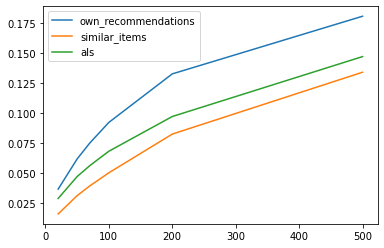

In [11]:
fig, ax = plt.subplots()
ax.plot(k_values, own_recommendations_recalls, label = 'own_recommendations')
ax.plot(k_values, similar_items_recalls, label = 'similar_items')
ax.plot(k_values, als_recommendations_recalls, label = 'als')
ax.legend()
plt.show()

In [12]:
TOPK_RECALL = 500
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.18061825158867673),
 ('als_rec', 0.14696938088995024),
 ('sim_item_rec', 0.13392286185439914)]

In [13]:
TOPK_PRECISION = 5
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.18872062663185182),
 ('als_rec', 0.12480417754569094),
 ('sim_item_rec', 0.0629765013054835)]

Лучший Recall дают own recomendations при k=500

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [14]:
N_PREDICT = 80
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1097398, 101..."


In [15]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
df_match_candidates.head(8)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640
0,2070,928263
0,2070,944588
0,2070,1032703
0,2070,1138596


### Check warm start

In [16]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [17]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (153200, 2) Users: 1915 Items: 4446


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [18]:
data_train_ranker

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2282320,222,41297772783,635,1120741,1,0.59,304,0.00,1716,91,0.0,0.0
2282321,462,41297773713,635,993339,1,1.99,304,0.00,2040,91,0.0,0.0
2282322,462,41297773713,635,995242,1,1.00,304,-0.89,2040,91,0.0,0.0
2282323,462,41297773713,635,10180324,1,3.00,304,-0.29,2040,91,0.0,0.0


In [19]:
df_ranker_train = data_train_ranker.copy()
df_ranker_train['target'] = 1
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')
df_ranker_train['target'].fillna(0, inplace= True)

In [20]:
df_ranker_train.loc[df_ranker_train['target'] == 0]

,user_id,item_id,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,target
0,2070,1105426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2070,1097350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2070,879194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2070,948640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2070,928263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157604,1745,941361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
157605,1745,866871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
157606,1745,1006184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
157607,1745,906923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


## Подготавливаем фичи для обучения модели

**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [21]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')
df_ranker_train.head(9)

,user_id,item_id,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
5,2070,944588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LUNCHMEAT,HAM,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
6,2070,1032703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,SEAFOOD - FROZEN,FRZN BRD STICK/PORTON,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
7,2070,1138596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CIGARETTES,CIGARETTES,523670 CTN,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
8,2070,1092937,4.094147e+10,619.0,1.0,3.29,311.0,0.0,2015.0,89.0,...,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


Фичи user_id

In [22]:
# Средний чек
df_ranker_train = pd.merge(df_ranker_train, 
                           df_ranker_train.loc[df_ranker_train['target'] == 1].groupby('user_id').apply(lambda x: (x['sales_value'] * x['quantity']).sum() / len(x)).reset_index(name='mean_receipt'), 
                           on='user_id')
# средняя сумма покупки в каждой категории
df_ranker_train['mean_sale_in_cat'] = df_ranker_train.groupby(['user_id', 'department'])['sales_value'].transform(np.mean)
# количество покупок в каждой категории
df_ranker_train['count_in_cat'] = df_ranker_train.groupby(['user_id', 'department'])['target'].transform(sum)

Фичи item_id

In [23]:
# Кол-во покупок в неделю - 
df_ranker_train['count_purchaces_in_week'] = df_ranker_train.groupby(['item_id', 'week_no'])['target'].transform(sum)
# Среднее ол-во покупок 1 товара в категории в неделю
df_ranker_train['mean_purchaces_in_week_in_cat'] = df_ranker_train.groupby(['item_id', 'week_no', 'department'])['target'].transform(np.mean)

Фичи пары user_id - item_id 

In [24]:
df_ranker_train['mean_sale_in_cat'] = df_ranker_train.groupby(['item_id', 'department'])['sales_value'].transform(np.mean)

In [25]:
df_ranker_train['users_count_purchaces_in_cat'] = df_ranker_train.groupby(['user_id', 'department'])['target'].transform(np.sum)

In [26]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [27]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

## Обучение модели ранжирования

In [28]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\Programs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Programs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Programs\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [29]:
df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

# Evaluation on test dataset

In [30]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


## Eval matching on test dataset

In [31]:
TOPK_PRECISION = 5

In [32]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

Wall time: 6.63 s


[('own_rec', 0.1462140992167092)]

## Eval re-ranked matched result on test dataset

In [33]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [34]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [35]:
result_eval_ranker['reranked_own_rec']

0               [856942, 8293439, 983897, 969403, 991024]
1        [13115971, 13115375, 1098844, 1098844, 12757544]
2         [1122358, 9338009, 12524016, 13213082, 9859017]
3         [1090507, 12808385, 9677670, 9859217, 12172240]
4          [12171886, 1029743, 1056005, 1029743, 9677424]
                              ...                        
1910         [1056509, 9487534, 5580577, 831509, 1056509]
1911         [870515, 1010950, 5590613, 1103513, 1120361]
1912    [1100379, 13910296, 13133916, 12949855, 10456152]
1913        [1079228, 1060872, 1060872, 869322, 13907062]
1914        [5566235, 1065538, 1065538, 1065538, 1013389]
Name: reranked_own_rec, Length: 1915, dtype: object

In [36]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.20843005497861733)
('own_rec', 0.1462140992167092)


C:\Users\Melnik DE\geekbrains\rec_sys\hw6\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


Метрика precision@5 при примененеии модели второго уровня выросла до с 0.146 до 0.208